<a href="https://colab.research.google.com/github/Gotchs/Alfa-Campus/blob/main/alfa_diplom_v3_21_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title ИДЕИ ПО УЛУЧШЕНИЮ:
'''
+ Для того, что дало результат
- Для того, что не дало результат

+0) ИСПРАВЛЕНО Было замечено, что в train_df у некоторых столбцов неверно задан тип данных. (string вместо float и наоборот)
-1) Сделать новый таргет на основе умножениявеса на таргет. Обучиться по новому таргету. Сделать предсказания по тесту. Умножить предиктына веса. # (Скорее всего не сработает. Т.к. мы не будем знать предсказанные 50к это 50к с весом 1 или 100к с весом 2)
-2) Высчитать среднюю зп по регионам для клиентов альфабанка исходя из таргета и области проживания # Не дало результата. Вроде кэт буст это делает автоматом для категориальных фичей
-3) Высчиать сренюю зп по сегментам  для клиентов альфабанка исходя из таргета и сегмента
+4) Сложить все траты(пересчитать какие надо на месяц), снятие наличных, высчитать среднемесячное изменение счетов и платежи по кредитам
-5) Попробовать добавить +/- к предсказанынм таргетам исходя из графика распределения таргета и веса
-6) Отобрать фичи # При отборе 61 фичи качество анчало падать
+/-7) Как заполнять 0 в числовых. Заполнить где должны будут 0 нулями. А где скорее всего не дложно быть 0, то заполнить по ближайшим соседям
+8) Поиграться с обучением только на клиентах с весом больше заданого порога
-9) Попробовать поместить в валидационную выборку больше высоковесовых клиентов
+10) Дать существенно больше итераций для обучения. До 900000 итераций
+11) Попробовать разный сплит выборки. (0,1 в итоге дало лучший результат)
 12) Сделать кросс валидацию для лучшей модели
+13) Попробовать заполнить пропущенные данные avg_debet_turn_rur высчитанынмизначениями по остальным тратам и снятиям наличных
-14) Попробовать автомль. PyCarret # Скорее всего не имеет смысла. ТОлько в конце попробовать отдельно обучить лучшие модели оттуда
+15) Поискать данные из открытых источников с зп по регионам
+16) Можно ли как то использовать дату в обучении?
-17) Попробовать коды с топ решений кагла по регрессии
 18) Написать вручную код, который будет оценивать качеств обученной модели по WMAE. Отправлять её на дообучение. Если после дообучения становится хуже, то возвращать предыдущую модель и снова пытаться отослать на дообучение. С порогом остановки после какого-то шага
-19) Поделить зп клиента на среднюю по региону
+20) Отдельно расплитить высоковесовых и низковесовых клиентов . Потом соединить и равномерно перемешать соединённые выборки
 21) Заполнить самые важные фичи липо по к-ближайшим соседям, либо средним по группе. (К примеру по региону проживания)
+22) Добавление обучение с учётом весов
+23) Указать MAE в трёх параметрах.
    objective = 'MAE',                            ПОСЛЕ ДОБАВЛЕНИЯ ЭТОЙ СТРОЧКИ ПОЧТИ ПРОПАЛО ПЕРЕОБУЧЕНИЕ И УДАЛОСЬ УЛУЧШИТЬ ЛУЧШИЙ СЧЁТ
    loss_function = 'MAE',                        Метрика функции потерь
    eval_metric = 'MAE',                          Метрика оценки качества обучения
+24) Увеличение глубины дерева до 10
+25) Блендинг лучших сабмитов
+26) Сделать новую среднемесячную фичу с тратами по всем категорям + выдача наличных + платёж по кредитам в других банках (7-9 место по важности). Но сейчас вышла на 2 место
 27) Сделать дубль категориальных фичей, которые можно привести в числовые
 28) Ещё почистить числовые фичи (оставить только траты и доходы в рублях)
+/-29) Попробовать откатить несколько итерации у лучшей модели чтобы посмотреть как изменится счёт WMAE и WMAE на Kaggle
-30) Убрать слишком редко встречающиеся значения в фичах. К примеру в фиче 10000 уникальных значений. Многие встречаются по 1-2 раза. Их все надо преобразовать в одну общую.
-31) Сделать логарифмическое преобразование таргета на обучении и обратое преобразование для предикта
+32) Увеличить лёнинг рейт (Последния вещь, которая дала существенный рывок). С 0.01 до 200 и потом до 4000
+33) Добавить новые фичи на основе даты для каждого месяца добавить ключевую ставку, инвляцию, курс доллара(12 месяцев трейна + месяц до трейна и + месяц теста)

ОСНОВНЫЕ ЭТАПЫ
- Фильтр строк по весам
- Подача веса в модель
- Настройка метрики МАЕ и её работы на GPU
- Очень сильное увеличение лёнинг рейта
- Фичи на основе даты
- Новые фичи из многих малозначительных + исправление фичи оборота по дебетовым картам

'one_hot_max_size': 2, разобраться как работает и будет ли улучшение качества модели если подать другую кодировку (возможно оставить уникальную фичу и изменённую)
'''

"\n+ Для того, что дало результат\n- Для того, что не дало результат\n\n+0) ИСПРАВЛЕНО Было замечено, что в train_df у некоторых столбцов неверно задан тип данных. (string вместо float и наоборот)\n-1) Сделать новый таргет на основе умножениявеса на таргет. Обучиться по новому таргету. Сделать предсказания по тесту. Умножить предиктына веса. # (Скорее всего не сработает. Т.к. мы не будем знать предсказанные 50к это 50к с весом 1 или 100к с весом 2)\n-2) Высчитать среднюю зп по регионам для клиентов альфабанка исходя из таргета и области проживания # Не дало результата. Вроде кэт буст это делает автоматом для категориальных фичей\n-3) Высчиать сренюю зп по сегментам  для клиентов альфабанка исходя из таргета и сегмента\n+4) Сложить все траты(пересчитать какие надо на месяц), снятие наличных, высчитать среднемесячное изменение счетов и платежи по кредитам\n-5) Попробовать добавить +/- к предсказанынм таргетам исходя из графика распределения таргета и веса\n-6) Отобрать фичи # При отборе 

# Импорт библиотек + задаём функции

In [ ]:
import pandas as pd
import numpy as np
import catboost
from catboost import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statistics import mean

# Определяем функцию взвешенной средней абсолютной ошибки
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return (weights * np.abs(y_true - y_pred)).mean()

In [ ]:

# Библиотеки для построения графиков
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from subprocess import check_output

In [ ]:
# Загружаем исходные данные
#train_df = pd.read_csv('train.csv', sep=";", decimal=",", encoding="windows-1251")
#test_df = pd.read_csv('test.csv', sep=";", decimal=",", encoding="windows-1251")

# Загружаем данные, отобранные и преобразованные в отдельном файле
train_df = pd.read_csv('add_train.csv', sep=",", decimal=";", encoding="utf-8",low_memory=False)
test_df = pd.read_csv('add_test.csv', sep=",", decimal=";", encoding="utf-8", low_memory=False)
train_df.shape, test_df.shape

((205962, 262), (37183, 260))

In [ ]:
add_train_df = pd.read_csv('train_new_feat.csv', sep=",", decimal=";", encoding="utf-8",low_memory=False)
add_test_df = pd.read_csv('test_new_feat.csv', sep=",", decimal=";", encoding="utf-8", low_memory=False)

In [ ]:
# Пытаемся конвертировать данные в тип float
for column in train_df.columns:
    try:
        train_df[column] = train_df[column].astype(float)
    except ValueError as e:
        print(f"Ошибка конвертации в столбце {column}: {e}")

Ошибка конвертации в столбце feature_date: could not convert string to float: '2023-06-30'
Ошибка конвертации в столбце addrref: could not convert string to float: 'Свердловская область'
Ошибка конвертации в столбце main_last_position_ccode: could not convert string to float: 'miss_value'
Ошибка конвертации в столбце main_pre_last_position_ccode: could not convert string to float: 'miss_value'
Ошибка конвертации в столбце oldest_campaignsegment_ccode_for_nss: could not convert string to float: 'miss_value'
Ошибка конвертации в столбце oldest_campaignsegment_ccode_for_pil: could not convert string to float: 'PIL2CC'
Ошибка конвертации в столбце part_last_position_ccode: could not convert string to float: 'miss_value'
Ошибка конвертации в столбце part_pre_last_position_ccode: could not convert string to float: 'miss_value'
Ошибка конвертации в столбце segment: could not convert string to float: 'Mass Affluent'
Ошибка конвертации в столбце brand: could not convert string to float: 'miss_v

In [ ]:
hhh = train_df
hhh

,client_id,feature_date,target,w,accum_rur_amt_cm_avg_div_v2,addrref,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__bilety_na_kontserty_i_v_teatry,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani,...,avg_salary_month,vpm_2024,avg_region_salary_2021,avg_region_salary_2022,ratio_more_100,ratio_less_200,min_typical_salary,max_typical_salary,2022,2023
0,0.000,2023-06-30,150000.000,0.681,0.000,Свердловская область,NaN,NaN,NaN,NaN,...,66947.000,14088.000,48590.000,55308.000,9.700,10.400,29.000,61.000,0.970,0.974
1,1.000,2023-01-31,96845.573,0.086,1.000,Новосибирская область,NaN,NaN,NaN,NaN,...,53274.000,14728.000,46167.000,53757.000,9.600,9.800,29.000,59.000,0.937,0.933
2,2.000,2023-03-31,60906.062,0.317,1.000,Новосибирская область,NaN,NaN,NaN,NaN,...,58308.000,14728.000,46167.000,53757.000,9.600,9.800,29.000,59.000,0.937,0.933
3,3.000,2023-02-28,65272.380,0.268,1.000,Московская область,NaN,NaN,NaN,NaN,...,72337.000,17277.000,64041.000,70705.000,17.000,6.700,37.000,79.000,1.091,1.096
4,4.000,2023-05-31,43999.770,0.507,1.000,Краснодарский край,NaN,NaN,NaN,NaN,...,55685.000,13800.000,43510.000,50252.000,6.400,14.100,26.000,55.000,1.010,1.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205957,208026.000,2022-11-30,60244.400,0.325,0.409,г. Санкт - Петербург,NaN,NaN,NaN,NaN,...,82449.000,15094.000,76259.000,86630.000,23.900,4.200,42.000,96.000,1.130,1.130
205958,208027.000,2023-07-31,120000.000,0.345,1.000,Краснодарский край,NaN,NaN,NaN,NaN,...,54820.000,13800.000,43510.000,50252.000,6.400,14.100,26.000,55.000,1.010,1.017
205959,208028.000,2022-09-30,385859.490,2.363,1.012,г. Москва,NaN,NaN,NaN,NaN,...,113895.000,21718.000,112768.000,125638.000,39.300,3.000,50.000,141.000,1.250,1.250
205960,208029.000,2022-11-30,94347.710,0.058,1.000,Воронежская область,NaN,NaN,NaN,NaN,...,46979.000,12363.000,40830.000,46277.000,5.900,14.600,26.000,53.000,0.913,0.913


In [ ]:
'''
# Объединим исходные и обработанные df
columns_to_add = add_train_df.columns.difference(train_df.columns)       # Найдем столбцы, которые есть в add_train_df, но отсутствуют в train_df
train_df = pd.concat([train_df, add_train_df[columns_to_add]], axis=1)   # Добавим только отсутствующие столбцы из add_train_df в train_df

# Тоже самое для тестового набора данных
columns_to_add = add_test_df.columns.difference(test_df.columns)
test_df = pd.concat([test_df, add_test_df[columns_to_add]], axis=1)
print(f'Размер df после объединения {train_df.shape}, {test_df.shape}')
'''

"\n# Объединим исходные и обработанные df\ncolumns_to_add = add_train_df.columns.difference(train_df.columns)       # Найдем столбцы, которые есть в add_train_df, но отсутствуют в train_df\ntrain_df = pd.concat([train_df, add_train_df[columns_to_add]], axis=1)   # Добавим только отсутствующие столбцы из add_train_df в train_df\n\n# Тоже самое для тестового набора данных\ncolumns_to_add = add_test_df.columns.difference(test_df.columns)\ntest_df = pd.concat([test_df, add_test_df[columns_to_add]], axis=1)\nprint(f'Размер df после объединения {train_df.shape}, {test_df.shape}')\n"

# Анализ данных. Дополнительный отбор фичей. Дополнительное добавление новых фичей

In [ ]:
# Создаём 6 новых колонок на основе комбинации помесячной даты с (ключевой ставкой, инфляцией, курсом доллара)
dates = sorted(train_df['feature_date'].unique())

key_rate = [0.08, 0.07773, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.07786, 0.10478, 0.12476]
inflation = [0.143, 0.1368, 0.1263, 0.1198, 0.1194, 0.1177, 0.1099, 0.0351, 0.0231, 0.0251, 0.0325, 0.043, 0.0515, 0.06]
usd = [60.3919, 59.8215, 61.1158, 60.853, 65.815, 68.876, 72.7828, 76.0353, 80.9955, 79.2126, 83.3193, 90.474, 95.2853, 96.6223]

# Создаём 4 новые колонки на основе комбинации помесячной даты с (денежной массой по данным центробанка)
broad_money = [85693.0, 86137.8, 86655.5, 87797.6, 94715.5, 94495.6, 97054.6, 97775.0, 97850.4, 99238.6, 100918.6, 102686.8, 105446.2, 106149.3 ] # Широкая денежная масса млрд рублей
broad_money_sa = [86072.7, 86684.4, 88206.7, 88950.2, 92377.3, 93214.9, 95150.8, 96519.8, 97722.5, 99925.5, 102253.4, 104046.6, 105877.8, 106871.4 ] # Широкая денежная масса млрд рублей сезонно скорректированная

init_cols = train_df.columns

for name, feature in zip(['key_rate', 'inflation', 'usd', 'broad_money', 'broad_money_sa'], [key_rate, inflation, usd, broad_money, broad_money_sa]):

    dates_dict = dict(map(lambda i,j : (i,j), dates, feature))
    train_df['new_prev_month_avg_' + name] = train_df['feature_date'].apply(lambda x: dates_dict[x])
    test_df['new_prev_month_avg_' + name] = [feature[-2]] * len(test_df)

    dates_dict = dict(map(lambda i,j : (i,j), dates, feature[1:]))
    train_df['new_this_month_avg_' + name] = train_df['feature_date'].apply(lambda x: dates_dict[x])
    test_df['new_this_month_avg_' + name] = [feature[-1]] * len(test_df)

#macro_feat = [col for col in train_df.columns if col not in init_cols]

# Добавляем новые фичи в список для обучения
#num_feat.extend(['key_rate', 'inflation', 'usd', 'broad_money', 'broad_money_sa'])
#feat_names.extend(['key_rate', 'inflation', 'usd', 'broad_money', 'broad_money_sa'])

train_df.shape, test_df.shape

((205962, 272), (37183, 270))

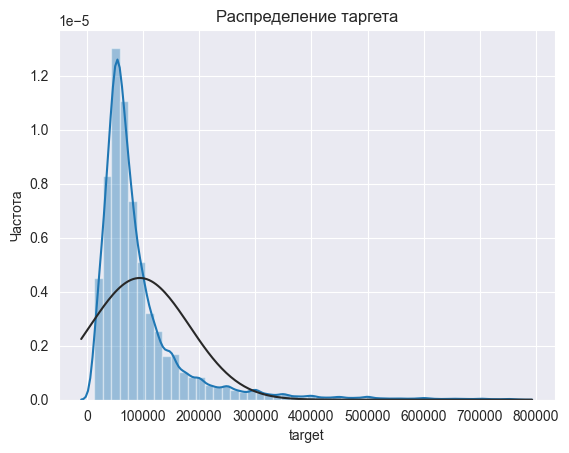

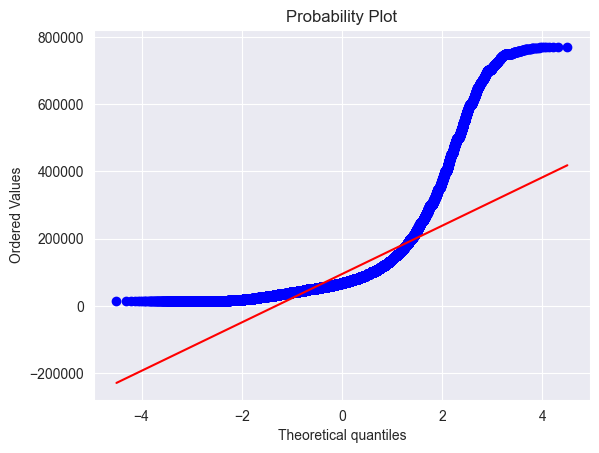

In [ ]:
# Смотрим на наш таргет
sns.distplot(train_df['target'] , fit=norm);

# Получаем параметры для отрисовки
#(mu, sigma) = norm.fit(train_df['target'])

# Строим распределение
plt.ylabel('Частота')
plt.title('Распределение таргета')

# Создание квантиль-plot
fig = plt.figure()
res = stats.probplot(train_df['target'], plot=plt)
plt.show()

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

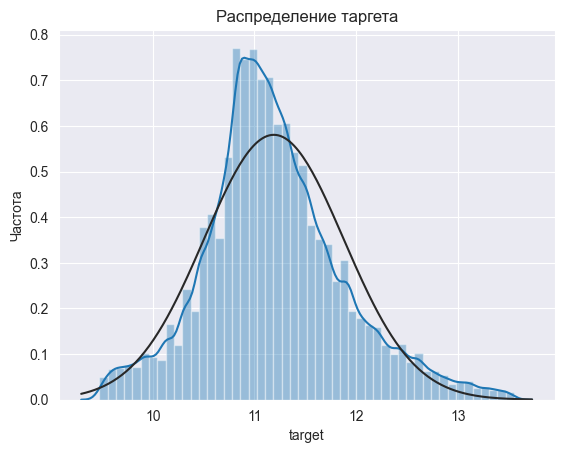

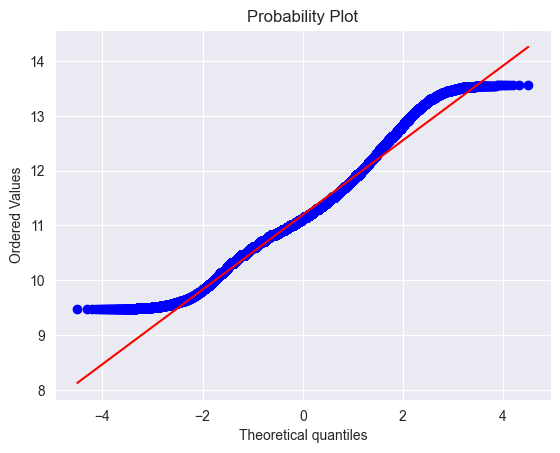

In [ ]:
'''# Делаем логарифмическое трансформирование
train_df["target"] = np.log1p(train_df["target"])

# Смотрим новое распределение
sns.distplot(train_df["target"], fit=norm);

plt.ylabel('Частота')
plt.title('Распределение таргета')

# Создание квантиль-plot
fig = plt.figure()
res = stats.probplot(train_df["target"], plot=plt)
plt.show()'''

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [ ]:
#@title Определяем колонки для удаления и выделяем оставшиеся фичи
del_columns = [
'client_id',
'feature_date',
'target',
'w',
'calls_weight_v2' # убираем. Если что подумать над использованием для сортировки аналогично колонке 'w'
]

print(f'Колонки, которые не будут участвовать в обучении: {del_columns}')

feat_names = [col for col in train_df.columns if col not in del_columns]
target = train_df['target']

#num_feat = [col for col in feat_names if train_df[col].dtype.name!='object']
#cat_feat = [col for col in feat_names if train_df[col].dtype.name=='object']

# Задаём вручную категориальные признаки т.к. автоматическое распределение неверное определяет категории. К примеру суммму максимального кредита
# Берём не все фичи, а только те, котрые выбраны и помечены зелёным цветом в гуглтаблицах

cat_feat = [
    'addrref',
    'main_last_position_ccode',
    'main_pre_last_position_ccode',
    'oldest_campaignsegment_ccode_for_nss',
    'oldest_campaignsegment_ccode_for_pil',
    'part_last_position_ccode',
    'part_pre_last_position_ccode',
    'segment',
    'brand',
    'model',
    'car_country'
]
print(f'Категориальных признаков выбрано: {len(cat_feat)} колонок')

# Формируем список числовых фичей путём вычитания категориального списка из общего
num_feat = [x for x in feat_names if x not in cat_feat]
print(f'Числовых признаков выбрано: {len(num_feat)} колонок')

Колонки, которые не будут участвовать в обучении: ['client_id', 'feature_date', 'target', 'w', 'calls_weight_v2']
Категориальных признаков выбрано: 11 колонок
Числовых признаков выбрано: 256 колонок


In [ ]:
# Смотрим описание категориальных признаков
#train_df[cat_feat].describe()

# Заполняем пропущенные категориальные значения 'no_data'
train_df[cat_feat] = train_df[cat_feat].fillna('no_data').astype(str)
test_df[cat_feat] = test_df[cat_feat].fillna('no_data').astype(str)

#@title Попробуем добавить новую фичу - среднюю заработную плату по регионам на основе выборки клиентов АльфаБанка

'''
# Задаём новую колонку для средней зарплаты и присваеваем по умолчанию 0 для всех строк
train_df['average_salary_region'] = 0
test_df['average_salary_region'] = 0

# Добавляем нашу новую фичу к списку числовых фичей и к списку общих фичей для обучения
num_feat.append('average_salary_region')
feat_names.append('average_salary_region')

# Находим уникальные значения в колонке регион addrref, высчитываем среднее для каждого региона и заполняем строки средним по региону
uniq_reg = train_df.addrref.unique()                                                                     # Находим уникальные значения регионов
for reg in uniq_reg:
    reg_df = train_df[train_df['addrref'] == reg].copy()                                                 # Делаем копию среза df чтобы избежать ошибки
    reg_df_test = test_df[test_df['addrref'] == reg].copy()                                              # Делаем копию среза df чтобы избежать ошибки
    reg_mean = reg_df['target'].mean()                                                                   # Находим реднюю зп по региону
    reg_df['average_salary_region'] = reg_mean                                                           # Устанавливаем в копированные df
    reg_df_test['average_salary_region'] = reg_mean

    train_df.loc[train_df['addrref'] == reg, 'average_salary_region'] = reg_df['average_salary_region']  # Обновляем исходный train_df
    test_df.loc[test_df['addrref'] == reg, 'average_salary_region'] = reg_df_test['average_salary_region']  # Обновляем исходный test_df

# Смотрим корректность заполнения новой колонки средней зп по региону
test_df[['average_salary_region','addrref']]
'''

print('Пустые категориальные фичи заполнены')

Пустые категориальные фичи заполнены


In [ ]:
# Делаем копию фичи рублёвого оборота с Лог-трансформацией
#train_df['new_avg_debet_turn_rur_2'] = np.log1p(train_df['avg_debet_turn_rur'])
#test_df['new_avg_debet_turn_rur_2'] = np.log1p(test_df['avg_debet_turn_rur'])
#num_feat.append('new_avg_debet_turn_rur_2')
#feat_names.append('new_avg_debet_turn_rur_2')

In [ ]:
# Пробуем создать новую фичу с среднемесячной суммой трат по известным категорям + выдача наличных в банкомате + среднемесячные платежи по кредитам(автокредиты)
# Т.е. мы  объединяем все маловажные по значимости(около 0) фичи в одну общую, которая по итогам обучения получала от 7 до 15 места в списке значимости

# Для создания этой фичи нам потребуются заполненные 0 значения Nan. Создадим копии исходных датафремов и заполним пропуски 0
train_df2 = train_df[num_feat].copy()
test_df2 = test_df[num_feat].copy()
train_df2 = train_df2[num_feat].fillna(0).astype(float)
test_df2 = test_df2[num_feat].fillna(0).astype(float)

# Определяем колонки для суммирования по всем известным среднемесячным тратам
columns_to_sum = [
                'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__bilety_na_kontserty_i_v_teatry',
                'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi',
                'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting',
                'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani',
                'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__tovary_dlja_detej',
                'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__turisticheskie_agenstva',
                'avg_3m_hotels',
                'avg_6m_building_services',
                'avg_6m_money_transactions',
                'avg_6m_personal_services',
                'avg_6m_transportation',
                'avg_by_category__amount__sum__cashflowcategory_name__detskie_igrushki',
                'avg_by_category__amount__sum__cashflowcategory_name__investitsii',
                'avg_by_category__amount__sum__cashflowcategory_name__odezhda_dlja_beremennyh',
                'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
                'avg_by_category__amount__sum__cashflowcategory_name__zdorove',
                'avg_by_category__amount__sum__cashflowcategory_name__zooparki',
                'by_category__amount__sum__eoperation_type_name__platezh_cherez_vidzhet_moj_mobilnyj',
                'by_category__amount__sum__eoperation_type_name__pokupka_paja',
                'by_category__amount__sum__eoperation_type_name__vneshnij_perevod_rur',
                'summarur_1m_miscellaneous_stores',
                'summarur_1m_no_cat'
                #'hdb_bki_other_active_auto_month_payments_sum' # Средний платёж по автокредиту в других банках
                ]
feats_90_to_30 =[
                'amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__marketplejsy',
                'amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__nalogi',
                'amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__ohota_i_rybalka',
                'amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__prochie_bilety',
                'transaction_category_supermarket_sum_amt_m3_4'
                ]
feats_60_to_30 =[
                'transaction_category_hotels_sum_amt_m2'
                ]
feats_15_to_30 =[
                'transaction_category_clothers_shoes_sum_amt_d15'
                ]


train_df2[feats_90_to_30] = train_df2[feats_90_to_30]/3  # Приводим сумму за 90 дней к среднемесячным тратам за 30 дней
train_df2[feats_60_to_30] = train_df2[feats_60_to_30]/2  # Приводим сумму за 60 дней к среднемесячным тратам за 30 дней
train_df2[feats_15_to_30] = train_df2[feats_15_to_30]*2  # Приводим сумму за 15 дней к среднемесячным тратам за 30 дней

columns_to_sum.extend(feats_90_to_30)
columns_to_sum.extend(feats_60_to_30)
columns_to_sum.extend(feats_15_to_30)

# Считаем на сколько в среднем в месяц менялся счёт. (+) Если деньги добавлялись и (-) Если деньги снимались. По скольку за 2 месяца. Значит делим на 2
train_df2['new_avg_rur_amt'] = np.round((train_df2['total_rur_amt_cm_avg_period_days_ago_v2'] * train_df2['total_rur_amt_cm_avg_div_v2'])/2) #Делим на 2 месяца и округляем дл среднего
test_df2['new_avg_rur_amt'] = np.round((test_df2['total_rur_amt_cm_avg_period_days_ago_v2'] * test_df2['total_rur_amt_cm_avg_div_v2'])/2)    #Делим на 2 месяца и округляем дл среднего
# Умножаем new_avg_rur_amt на -1 для тех клиентов, у которых total_rur_amt_cm_avg_div_v2 меньше 1 (денег стало меньше. значит они выводили деньги со счетов)
# Записываем значенич сразу в основные таблицы train_df и test_df
train_df['new_avg_rur_amt'] = train_df2.apply(lambda row: row['new_avg_rur_amt'] * -1 if row['total_rur_amt_cm_avg_div_v2'] < 1 else row['new_avg_rur_amt'], axis=1)
test_df['new_avg_rur_amt'] = test_df2.apply(lambda row: row['new_avg_rur_amt'] * -1 if row['total_rur_amt_cm_avg_div_v2'] < 1 else row['new_avg_rur_amt'], axis=1)

# Считаем сумму трат за месяц по известным позициям (сколько клиент в среднем тратит денег за месяц для известных позиций)
train_df['new_avg_spending_30_days'] = train_df2[columns_to_sum].sum(axis=1)
train_df['new_avg_spending_30_days'] = train_df['new_avg_spending_30_days'] + train_df2['hdb_bki_other_active_auto_month_payments_sum']   # Добавляем сумму трат по автокредитам в других банках
train_df['new_avg_spending_30_days'] = np.round(train_df['new_avg_spending_30_days']) # Округляем до целых чисел

test_df['new_avg_spending_30_days'] = test_df2[columns_to_sum].sum(axis=1)
test_df['new_avg_spending_30_days'] = test_df['new_avg_spending_30_days'] + test_df2['hdb_bki_other_active_auto_month_payments_sum']   # Добавляем сумму трат по автокредитам в других банках
test_df['new_avg_spending_30_days'] = np.round(test_df['new_avg_spending_30_days']) # Округляем до целых чисел

# Считаем сколько новых стредств в среднем (без учёта снятых и положенных денег на дебетовые счета) ежемесячно тратят клиенты.
train_df['new_avg_clean_money_30_days'] = train_df['new_avg_spending_30_days'] + train_df['new_avg_rur_amt']
test_df['new_avg_clean_money_30_days']  = test_df['new_avg_spending_30_days'] + test_df2['new_avg_rur_amt']

# Создаём аналог лучшей фичи (avg_debet_turn_rur) с оборотом денежных средств по известынм категорям для счетов АльфаБанка
train_df['new_avg_debet_turn_rur'] = train_df['new_avg_spending_30_days'] + abs(train_df['new_avg_rur_amt']) - train_df2['hdb_bki_other_active_auto_month_payments_sum'] # Берём модуль изменения счёта чтобы посчиатть оборот и вычитаем платежи автокредитов в других банках т.к. они не входят в оборот по счетам альфабанка
test_df['new_avg_debet_turn_rur']  = test_df['new_avg_spending_30_days'] + abs(test_df2['new_avg_rur_amt']) - test_df2['hdb_bki_other_active_auto_month_payments_sum']   # Берём модуль изменения счёта чтобы посчиатть оборот и вычитаем платежи автокредитов в других банках т.к. они не входят в оборот по счетам альфабанка

# Заменям на NaN все 0 в нашей новой фиче
train_df.loc[train_df['new_avg_spending_30_days'] == 0, 'new_avg_spending_30_days'] = np.nan
test_df.loc[test_df['new_avg_spending_30_days'] == 0, 'new_avg_spending_30_days'] = np.nan

# Делаем копию самого важного столбца avg_debet_turn_rur и пытаемся заполнить пропущенные и 0_ые значения данными с нашего нового аналога оборота new_avg_debet_turn_rur
# Создание независимой копии столбца
train_df['new_v2_avg_debet_turn_rur'] = train_df['avg_debet_turn_rur'].copy()
test_df['new_v2_avg_debet_turn_rur'] = test_df['avg_debet_turn_rur'].copy()
# Замена NaN значениями из столбца new_avg_debet_turn_rur
train_df['new_v2_avg_debet_turn_rur'] = train_df['new_v2_avg_debet_turn_rur'].fillna(train_df['new_avg_debet_turn_rur'])#.replace(0, train_df['new_avg_debet_turn_rur'])
test_df['new_v2_avg_debet_turn_rur'] = test_df['new_v2_avg_debet_turn_rur'].fillna(test_df['new_avg_debet_turn_rur'])#.replace(0, test_df['new_avg_debet_turn_rur'])
# Замена 0_ей значениями из столбца new_avg_debet_turn_rur
train_df['new_v2_avg_debet_turn_rur'] = train_df.apply(lambda row: row['new_avg_debet_turn_rur'] if row['new_v2_avg_debet_turn_rur'] == 0 else row['new_v2_avg_debet_turn_rur'], axis=1)
test_df['new_v2_avg_debet_turn_rur'] = test_df.apply(lambda row: row['new_avg_debet_turn_rur'] if row['new_v2_avg_debet_turn_rur'] == 0 else row['new_v2_avg_debet_turn_rur'], axis=1)

# Добавляем новые фичи в список для обучения
num_feat.extend(['new_avg_spending_30_days','new_avg_rur_amt','new_avg_clean_money_30_days','new_avg_debet_turn_rur','new_v2_avg_debet_turn_rur'])
feat_names.extend(['new_avg_spending_30_days','new_avg_rur_amt','new_avg_clean_money_30_days','new_avg_debet_turn_rur','new_v2_avg_debet_turn_rur'])

# В результате получили новые фичи:
#'new_avg_spending_30_days'         Среднемесячные суммы трат по всем известым категориям
#'new_avg_rur_amt'                  Среднемесячное изменение баланса дебетового счёта
#'new_avg_clean_money_30_days'      Среднемесячные суммы трат без использования накопленных средств (к примеру потратил в месяце 100000р. Из них 80000 заработаные и 20000 снял с накопительного счёта)
#'new_avg_debet_turn_rur'           Аналог лучшей фичи дебетовго оборота avg_debet_turn_rur. Только посчитана для известных категорий
#'new_v2_avg_debet_turn_rur         Копия лучшей фичи дебетовго оборота avg_debet_turn_rur. В которой отсутствующие и 0 значения заменены из new_avg_debet_turn_rur'

# Поиск возможных аномалий в строках по зп в таргете и среднемесячным оборотам
# К примеру есть клиенты с доходом в таргете 50000 рублей и оборотом по счетам в миллиарды рублей.
# Считаем anomaly по train_df2 с замолненными 0 и записываем результаты в главную таблицу (Чтобы избежать попадание Nan в главную таблицу)
# Нужно на случай если решим убирать аномалии из тренировочного набора, но сохранить в валидации
train_df['anomaly'] = train_df2['avg_debet_turn_rur']/train_df['target']

In [ ]:
# Сохраняем новые фичи для ипорта в другие блокноты
#train_df[['new_avg_spending_30_days','new_avg_rur_amt','new_avg_clean_money_30_days','new_avg_debet_turn_rur','new_v2_avg_debet_turn_rur']].to_csv('train_new_feat.csv')
#test_df[['new_avg_spending_30_days','new_avg_rur_amt','new_avg_clean_money_30_days','new_avg_debet_turn_rur','new_v2_avg_debet_turn_rur']].to_csv('test_new_feat.csv')

In [ ]:
# Постепенно убираем фичи, которые дают 0_ой результат на луших моделях. При попытке сразу убрать много по корреляции, заполности, рандомной фиче результаты стали сильно хуже
del_columns_2 = [
'product_zarplatnyj_proekt_voc_features_12m_mark_eq_3_flag',
'channel_collection_voc_features_36m_voc_not_null_flag',
'channel_collection_voc_features_3m_voc_with_expert_portion',
'channel_collection_voc_features_full_voc_without_marks_portion',
'channel_chatbot_alfainvestitsii_voc_features_3m_mark_in_4_5_flag',
'channel_chatbot_alfainvestitsii_voc_features_full_avg_mark',
'channel_chatbot_alfainvestitsii_voc_features_36m_min_mark',
'channel_chatbot_alfainvestitsii_voc_features_12m_voc_with_expert_portion',
'channel_finansovyj_sovetnik_voc_features_36m_avg_mark',
'channel_finansovyj_sovetnik_voc_features_full_avg_mark',
'channel_finansovyj_sovetnik_voc_features_full_voc_with_expert_cnt',
'channel_finansovyj_sovetnik_voc_features_3m_voc_with_expert_portion',
'channel_telemarketing__bot_voc_features_36m_mark_not_null_flag',
'channel_telemarketing__bot_voc_features_3m_avg_mark',
'channel_predstavitelstvo_voc_features_36m_min_mark',
'channel_predstavitelstvo_voc_features_36m_voc_without_marks_portion',
'channel_otdelenija_voc_features_full_voc_not_null_flag',
'channel_mobilnoe_prilozhenie_ai_voc_features_36m_mark_in_4_5_flag',
'channel_mobilnoe_prilozhenie_ai_voc_features_full_mark_eq_2_flag',
'channel_mobilnoe_prilozhenie_ai_voc_features_36m_voc_with_expert_cnt',
'channel_glid_voc_features_12m_mark_in_1_3_flag',
'channel_frodmonitoring_voc_features_full_voc_not_null_flag',
'channel_frodmonitoring_voc_features_12m_mark_eq_2_flag',
'channel_agentskij_kanal_voc_features_12m_avg_mark',
'amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__ohota_i_rybalka',
'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani',
'by_category__amount__sum__eoperation_type_name__platezh_cherez_vidzhet_moj_mobilnyj',
'by_category__amount__sum__eoperation_type_name__perevod_mezhdu_svoimi_schetami',
'avg_by_category__amount__sum__cashflowcategory_name__odezhda_dlja_beremennyh',
'avg_by_category__amount__sum__cashflowcategory_name__zooparki',
'min_clip_max_ul_actoff_90_30_inc',
'lalifeinsurance',
'prod_page_travel_30',
'prod_anketa_cc_7',
'prod_page_pil_clicks_90',
'mortgage_main_3',
'channel_chatbot_alfainvestitsii_voc_features_12m_mark_in_4_5_flag',
'channel_collection_voc_features_36m_mark_eq_2_flag',
'product_zarplatnyj_proekt_voc_features_36m_avg_mark',
'channel_agentskij_kanal_voc_features_12m_cnt_mark',
'prod_page_sa_30',
'amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__prochie_bilety',
'channel_predstavitelstvo_voc_features_3m_voc_not_null_flag',
'productionyear',
'channel_predstavitelstvo_voc_features_12m_mark_eq_5_flag',
'channel_collection_voc_features_36m_cnt_mark',
'channel_kts_alfainvestitsii_voc_features_full_mark_eq_4_flag',
'channel_chatbot_alfainvestitsii_voc_features_36m_mark_eq_3_flag',
'prod_anketa_pil_refin_30',
'product_zarplatnyj_proekt_voc_features_3m_mark_in_1_3_flag',
'channel_glid_voc_features_12m_mark_eq_3_flag',
'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__turisticheskie_agenstva',
'prod_page_pil_90',
'channel_bankomaty_voc_features_36m_avg_mark',
'product_other_comm_cur_status_hy',
'loan_on_realty_clicks_90',
'channel_vyezdnoj_kanal_voc_features_12m_voc_with_expert_portion',
'channel_mobilnoe_prilozhenie_am_voc_features_12m_voc_with_expert_cnt',
'channel_glid_voc_features_36m_mark_in_4_5_flag',
'product_debetovye_karty_voc_features_full_mark_eq_2_flag',
'channel_kts_alfainvestitsii_voc_features_12m_mark_eq_1_flag',
'channel_frodmonitoring_voc_features_3m_mark_in_4_5_flag',
'channel_frodmonitoring_voc_features_12m_max_mark',
'channel_chatbot_alfainvestitsii_voc_features_3m_mark_eq_5_flag',
'channel_glid_voc_features_3m_mark_eq_1_flag',
'commexist_1_flg30_sum_v2',
'product_zarplatnyj_proekt_voc_features_36m_cnt_mark',
'product_kreditnye_karty_voc_features_3m_mark_eq_1_flag',
'channel_mobilnoe_prilozhenie_am_voc_features_12m_mark_eq_1_flag',
'channel_ivr_voc_features_full_mark_eq_3_flag',
'channel_ivr_voc_features_3m_mark_eq_5_flag',
'channel_kts_alfainvestitsii_voc_features_12m_mark_eq_1_flag',
'channel_frodmonitoring_voc_features_3m_mark_in_4_5_flag',
'channel_frodmonitoring_voc_features_12m_max_mark',
'channel_chatbot_alfainvestitsii_voc_features_3m_mark_eq_5_flag',
'channel_glid_voc_features_3m_mark_eq_1_flag',
# На исключённых выше фичах получилась лучшая модель 3.8_WMAE29227. Пробуем убрать ещё фичи с 0 значением. Запишем их ниже
'channel_chat_s_operatorom_voc_features_3m_mark_eq_4_flag',
'channel_mobilnoe_prilozhenie_am_voc_features_3m_max_mark',
'channel_chat_s_operatorom_voc_features_12m_voc_with_expert_cnt',
'product_zarplatnaja_karta_voc_features_3m_voc_with_expert_cnt',
'channel_telemarketing_voc_features_full_mark_eq_2_flag',
'channel_chat_s_operatorom_alfainvestitsii_voc_features_12m_avg_mark',
'product_auto_loan_ratio_hy',
'product_brokerskoe_obsluzhivanie_voc_features_3m_mark_eq_3_flag',
'product_debetovye_karty_voc_features_36m_mark_in_1_3_flag',
'product_ipoteka_voc_features_36m_mark_eq_1_flag',
'channel_chat_s_operatorom_alfainvestitsii_voc_features_36m_mark_not_null_flag',
# На исключённых выше фичах получилась лучшая модель 3.17_WMAE 27281. Пробуем убрать ещё фичи. Запишем их ниже. Версия блокнота 3.19
'part_pre_last_position_ccode',
'main_pre_last_position_ccode',
'flg_clip_cc_presence_in_previous_30_days_with_150_offset',
'min_cc_max_ul_actoff_180_30_inc',
'channel_telemarketing_voc_features_3m_voc_not_null_flag',
'channel_pretenzii_voc_features_full_avg_mark',
'channel_otdelenija_voc_features_full_mark_eq_1_flag',
'min_cc_max_pilot_score_actoff_180d',
'voc_features_full_mark_eq_3_flag',
'hdb_bki_active_micro_max_outstand',
'channel_bankomaty_voc_features_3m_mark_eq_5_flag',
'product_kreditnye_karty_voc_features_full_mark_not_null_flag',
'flg_nss_presence_in_previous_30_days_with_150_offset',
'product_debetovye_karty_voc_features_full_mark_not_null_flag',
'channel_pretenzii_voc_features_3m_mark_in_4_5_flag',
'channel_ivr_voc_features_36m_voc_not_null_flag',
'vcu_other_rate_max_2avg_prop',
'product_kreditnye_karty_voc_features_36m_min_mark',
'product_ipoteka_voc_features_12m_mark_eq_5_flag',
'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi',
'product_debetovye_karty_voc_features_full_min_mark',
'product_kreditnye_karty_voc_features_36m_voc_with_expert_cnt',
'product_brokerskoe_obsluzhivanie_voc_features_36m_voc_with_expert_cnt',
'product_ipoteka_voc_features_3m_mark_in_4_5_flag',
'product_kreditnye_karty_voc_features_12m_avg_mark',
'product_brokerskoe_obsluzhivanie_voc_features_36m_mark_eq_2_flag',
'channel_frodmonitoring_voc_features_3m_voc_without_marks_portion',
'channel_chat_s_operatorom_voc_features_12m_mark_eq_3_flag',
'product_ipoteka_voc_features_3m_mark_not_null_flag',
'product_debetovye_karty_voc_features_full_voc_with_expert_cnt',
'product_brokerskoe_obsluzhivanie_voc_features_3m_min_mark',
'channel_bankomaty_voc_features_full_voc_not_null_flag',
'new_this_month_avg_broad_money_sa',
'product_debetovye_karty_voc_features_36m_min_mark',
'channel_bankomaty_voc_features_full_mark_eq_5_flag',
'product_ipoteka_voc_features_full_mark_eq_3_flag',
'channel_otdelenija_voc_features_full_mark_eq_4_flag',
'amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting'
]

print(f'Количество колонок feat_names до удаления: {len(feat_names)}')
print(f'Количество колонок num_feat до удаления: {len(num_feat)}')
print(f'Количество колонок cat_feat до удаления: {len(cat_feat)}')

# Удаляем из списков фичи, которые есть в списке del_columns_2
feat_names = [x for x in feat_names if x not in del_columns_2]
num_feat = [x for x in num_feat if x not in del_columns_2]
cat_feat = [x for x in cat_feat if x not in del_columns_2]

print(f'Количество колонок feat_names после удаления: {len(feat_names)}')
print(f'Количество колонок num_feat после удаления: {len(num_feat)}')
print(f'Количество колонок cat_feat после удаления: {len(cat_feat)}')

Количество колонок feat_names до удаления: 272
Количество колонок num_feat до удаления: 261
Количество колонок cat_feat до удаления: 11
Количество колонок feat_names после удаления: 152
Количество колонок num_feat после удаления: 143
Количество колонок cat_feat после удаления: 9


In [ ]:
# Видим, что одна из самых важных фичей (часто самая важная) avg_debet_turn_rur заполнена как 0 так и NaN.
# Если посмотреть в связке с total_rur_amt_cm_avg_div_v2	total_rur_amt_cm_avg_period_days_ago_v2, то видно,
# что у некоторых клиентов менялся баланс личных средств (значение не равно 1), хотя в обороте стоит 0.
# Возможно это ошибки и надо заменить либо все 0 на Nan, либо только те, в строках которых total_rur_amt_cm_avg_div_v2 не равно 1
#(Т.е. состояние собственных средств на счетах изменялось, но при этом в обороте стоит 0)
ddd = train_df[['target','new_avg_spending_30_days','avg_debet_turn_rur','total_rur_amt_cm_avg_div_v2','total_rur_amt_cm_avg_period_days_ago_v2']]

# avg_debet_turn_rur            Средний дебетовый оборот по всем счетам за 3 месяца
# total_rur_amt_cm_avg_div_v2   Отношение среднего за текущий месяц Собственных средств клиента на дату расчета к средней сумме Собственных средств на 2 месяца ранее
# new_avg_spending_30_days      Новая фича. Среднемесячнаясумма трат по всем известынмкатегориям + выдача наличных + платёж по автокредитам

ddd

,target,new_avg_spending_30_days,avg_debet_turn_rur,total_rur_amt_cm_avg_div_v2,total_rur_amt_cm_avg_period_days_ago_v2
0,150000.000,49538.000,325430.000,0.181,121843.000
1,96845.573,23915.000,498734.000,2.271,11270.000
2,60906.062,88525.000,461033.000,0.577,34621.000
3,65272.380,120035.000,279099.000,1.090,20636.000
4,43999.770,648807.000,1109312.000,0.180,470223.000
...,...,...,...,...,...
205957,60244.400,477358.000,262657.000,0.105,63853.000
205958,120000.000,NaN,56.000,179.000,0.000
205959,385859.490,705450.000,3449994.000,0.530,161762.000
205960,94347.710,95240.000,13135.000,1.000,0.000


![image_2024-02-25_15-24-16.png](attachment:image_2024-02-25_15-24-16.png)

In [ ]:
# Пробуем заменить все 0 в avg_debet_turn_rur на значения NaN
#train_df['avg_debet_turn_rur'] = train_df['avg_debet_turn_rur'].replace(0, float('nan'))
#test_df['avg_debet_turn_rur'] = test_df['avg_debet_turn_rur'].replace(0, float('nan'))

# Заменим все значения 0 в столбце 'avg_debet_turn_rur' на NaN, где 'total_rur_amt_cm_avg_div_v2' не равно 1
#train_df.loc[train_df['total_rur_amt_cm_avg_div_v2'] != 1, 'avg_debet_turn_rur'] = train_df.loc[train_df['total_rur_amt_cm_avg_div_v2'] != 1, 'avg_debet_turn_rur'].replace(0, np.nan)
#test_df.loc[test_df['total_rur_amt_cm_avg_div_v2'] != 1, 'avg_debet_turn_rur'] = test_df.loc[test_df['total_rur_amt_cm_avg_div_v2'] != 1, 'avg_debet_turn_rur'].replace(0, np.nan)

#train_df['avg_debet_turn_rur'] = train_df['avg_debet_turn_rur'].fillna(train_df['new_avg_spending_30_days'])
#test_df['avg_debet_turn_rur'] = test_df['avg_debet_turn_rur'].fillna(test_df['new_avg_spending_30_days'])

#train_df.loc[train_df['avg_debet_turn_rur'] == 0, 'avg_debet_turn_rur'] = train_df['new_avg_spending_30_days']
#test_df.loc[test_df['avg_debet_turn_rur'] == 0, 'avg_debet_turn_rur'] = test_df['new_avg_spending_30_days']

In [ ]:
# Находим самые популярные значения
#top_3_values = train_df['addrref'].value_counts().nlargest(10).index # nlargest(3) три самых популярных

# Заменить все значения, не входящие в топ-nlargest(), на 'no_data'
#train_df.loc[~train_df['addrref'].isin(top_3_values), 'addrref'] = 'no_data'
#test_df.loc[~test_df['addrref'].isin(top_3_values), 'addrref'] = 'no_data'

In [ ]:
# Отбор по корреляции

def feats_filter_corr(df: pd.DataFrame,
                      features: list,
                      corr_threshold: float):

    """Функция отбора фичей по корреляции между фичами.
    Фичи, которые коррелируют с показателем не менее corr_threshold, подлежат
      удалению (из пары коррелирующих фичей удаляется менее заполненная фича).
      Используется метод df[features].corr() с корреляцией Пирсона.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    corr_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """
    cat_features = df[features].select_dtypes(include=['object']).columns
    df_tmp = df[features]
    df_tmp[cat_features] = df[cat_features].apply(lambda x: pd.factorize(x)[0])
    features_corr = df_tmp.corr()
    res = features.copy()

    def delete_in_selected_features(res_list: list, worst_feature: str):
      if worst_feature in res_list:
        res_list.remove(worst_feature)

    for i in range(len(features)-1):
      for j in range(i+1, len(features)):
        if abs(features_corr.iloc[i][j]) >= corr_threshold:
          if features[i] in cat_features and features[j] in cat_features:
            if df[features[i]].isin(['no_data']).sum() <= df[features[j]].isin(['no_data']).sum():
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])

          elif features[i] in cat_features and features[j] not in cat_features:
            if df[features[i]].isin(['no_data']).sum() < df[features[j]].isna().sum():
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])

          elif features[i] not in cat_features and features[j] in cat_features:
            if df[features[i]].isna().sum() < df[features[j]].isin(['no_data']).sum():
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])

          else:
            if df[features[i]].isna().sum() < df[features[j]].isna().sum():
              delete_in_selected_features(res, features[j])
            else:
              delete_in_selected_features(res, features[i])
    return res
print(len(feat_names))
feat_names = feats_filter_corr(train_df, feat_names, 0.98)    # 0.95
num_feat = [feat for feat in num_feat if feat in feat_names]
cat_feat = [feat for feat in cat_feat if feat in feat_names]
print(len(feat_names))

152
141


In [ ]:
'''# Добавляем по 4 метки классификатора для наших данных
clf_train_df = pd.read_csv('train_clf_features.csv', sep=",", decimal=";", encoding="utf-8",low_memory=False)
clf_test_df = pd.read_csv('test_clf_features.csv', sep=",", decimal=";", encoding="utf-8", low_memory=False)

train_df = train_df.join(clf_train_df)
test_df = test_df.join(clf_test_df)

feat_names.extend(['cl0_prob','cl1_prob','cl2_prob','target_bins'])'''

'# Добавляем по 4 метки классификатора для наших данных\nclf_train_df = pd.read_csv(\'train_clf_features.csv\', sep=",", decimal=";", encoding="utf-8",low_memory=False)\nclf_test_df = pd.read_csv(\'test_clf_features.csv\', sep=",", decimal=";", encoding="utf-8", low_memory=False)\n\ntrain_df = train_df.join(clf_train_df)\ntest_df = test_df.join(clf_test_df)\n\nfeat_names.extend([\'cl0_prob\',\'cl1_prob\',\'cl2_prob\',\'target_bins\'])'

In [ ]:
# Случайное перемешивание строк в DataFrame
#train_df_df = train_df.sample(frac=1, random_state=777).reset_index(drop=True)

# В ходе экспериментов было замечено, что точность метрики WMAE будет увеличиваться, если удалить из обучения строки с низким значением веса 'w'
# Для обучения оставляем строки, где значение веса 'w' больше заданного параметра
# Точность метрики MAE упадёт, но точноть WMAE растёт при определённом пороге 'w' >= 0.19 за счёт того, что учимся только на высокозначимых строках по колонке 'w'
# Были испробованы пороги 0.05 0.1 0.15 0.19 0.2 0.24 0.3 0.5 (Порядок от лучшего к худшему 0.19 0.2 0.24 0.15 0.1 0.3 0.05 0.5) для RMSE без учёта веса.
# При расчёте с учётом веса лучшим значеним похоже является 0.0001 для метрики MAE. Если брать без разделения по весу вообще, то качество падает.

w = 0.0001  #0.0001
train_df2 = train_df[train_df['w'] < w] # < 0.19    0.1   0.03
train_df = train_df[train_df['w'] >= w] #>= 0.19    0.1   0.03
print(train_df.shape)
print(train_df2.shape)

(205937, 278)
(25, 278)


In [ ]:
seed_split = 46 # 46
val_size = 0.1 # В началае теста 0.30 - 0.35 показывало результаты значительно выше. Но потом всё поменялось в обратную сторону.

# Делаем копию списка фич для обучения с добавлением ещё трёх фич. Нужно чтобы потом убрать строки с аномалией из трейна, но оставить в валидации.
#feat_names_2 = feat_names.copy()
#feat_names_2.extend(['anomaly','target','w'])

# Сплит выборки.
X_train, X_test, y_train, y_test = train_test_split(train_df[feat_names], train_df[['target','w']], random_state=seed_split, test_size=val_size)
#X_train, X_test, y_train, y_test = train_test_split(train_df[feat_names_2], train_df[['target','w']], random_state=seed_split, test_size=val_size)

# Сплит выборки #2
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_df2[feat_names], train_df2[['target','w']], random_state=seed_split, test_size=val_size)

# Добавляем к нашей валидационной выборке процентное (val_size) значение из train_df2
X_test = pd.concat([X_test, X_test2])
y_test = pd.concat([y_test, y_test2])

# Подумать как лучше убрать аномалии только из трейна, сохранив в валидации
#X_train[['target','w']] = y_train[['target','w']]
#X_train = X_train[X_train['anomaly'] < 300] # Оставляем только строки с значением аномалии меньше 3000 раз (возможно нужно оставить только тех, кто меньше 300)

# Перемешиваем тренировочную выборку
#X_train = X_train.sample(frac=1, random_state=seed).reset_index(drop=True)
#y_train = y_train.sample(frac=1, random_state=seed).reset_index(drop=True)

# Веса обучающих и валидационных образцов
#weight_train = X_train['w']    # Если используем фильтр аномалии
weight_train = y_train['w']     # Если НЕ используем фильтр аномалии
weight_val = y_test['w']

#y_train = X_train['target']    # Если используем фильтр аномалии
y_train = y_train['target']     # Если НЕ используем фильтр аномалии
y_test = y_test['target']

#X_train = X_train[feat_names]   # Возвращаем тренировочной выборке исходные колонки
#y_test_orig = y_test.copy()    # Делаем копию оригинального валидационного трейна для оценки WMAE (на случай если будем делать логарифмирование y_test)

print(f'Размер тренировочной выборки {X_train.shape}')
print(f'Размер валидационной выборки {X_test.shape}')

Размер тренировочной выборки (185343, 141)
Размер валидационной выборки (20597, 141)


In [ ]:
'''# Добавляем по 4 метки классификатора для наших данных
clf_train_df = pd.read_csv('clf_train.csv', sep=",", decimal=";", encoding="utf-8",low_memory=False)
clf_test_df = pd.read_csv('clf_val.csv', sep=",", decimal=";", encoding="utf-8", low_memory=False)

X_train = train_df.join(clf_train_df)
X_test = test_df.join(clf_test_df)

feat_names.extend(['cl0_prob','cl1_prob','cl2_prob','target_bins'])'''

'# Добавляем по 4 метки классификатора для наших данных\nclf_train_df = pd.read_csv(\'clf_train.csv\', sep=",", decimal=";", encoding="utf-8",low_memory=False)\nclf_test_df = pd.read_csv(\'clf_val.csv\', sep=",", decimal=";", encoding="utf-8", low_memory=False)\n\nX_train = train_df.join(clf_train_df)\nX_test = test_df.join(clf_test_df)\n\nfeat_names.extend([\'cl0_prob\',\'cl1_prob\',\'cl2_prob\',\'target_bins\'])'

# Обучение модели CatBoost

In [ ]:
# Дообучиваем модель на предварительно обученной модели
#pretrained_model = CatBoostRegressor()
#pretrained_model.load_model("/content/drive/MyDrive/model_best_kaggle") # model_лучшая_kaggle

# Тренировочная дата
train_data = Pool(
    data = X_train,
    label = y_train,
    cat_features=cat_feat,
    weight = weight_train # Если хотим учиться с учётом веса
    )

# Валидационная дата
eval_data = Pool(
    data = X_test,
    label = y_test,
    cat_features=cat_feat,
    weight = weight_val # Если хотим учиться с учётом веса
    )

lr = 4500 # 4500
depth = 8 # 8

model = CatBoostRegressor(
    task_type='GPU',
    iterations = 10000,          # 200000
    learning_rate = lr,           # Лучший счёт с learning_rate = 0.047009 для RMSE без веса  # Перспекртивный счёт learning_rate = 0.02  #  0.005 # 200 # Похоже сейчас самый лучший на 2000
    early_stopping_rounds = 1000, # Возможно стоит ставить значение меньше 3000 чтобы избежать переобучения. И точно меньше 12000. Т.к. валидация улучшается, но тест становится заметно хуже.
    objective = 'MAE',            # Метрика оптимизации ункции потерь
    loss_function = 'MAE',        # Синоним верхней метрики. Но пусть будет))
    eval_metric = 'MAE',          # Метрика оценки качества обучения
    custom_metric=['MAE'],
    #fold_permutation_block = 100,
    #one_hot_max_size = 250,
    #grow_policy='Lossguide',     # grow_policy='symmetric' или 'Lossguide'
    #l2_leaf_reg = 5.378491402,    # По умолчанию = 3
    #random_strength = 2.9149158,  # По умолчанию = 1
    #one_hot_max_size = 4,        # По умолчанию = 2
    depth=depth                   # По умолчанию depth=6
    #max_leaves=64,               # По умолчанию max_leaves=64
    #random_state=33
    #save_snapshot=True,
    #snapshot_file='shapshot.bkp', # Файл с прогрессом обучения
    #snapshot_interval=1,          # Интервал с которым делается снэпшот
    )

# Пробуем обучить на параметрах лучшей модели
#all_params = model_load.get_all_params()    # Посмотреть параметры загруженной модели(загружаем лучшую)
#unsupported_params = ['pinned_memory_bytes']  # Указываем здесь неподдерживаемые параметры
#all_params = {k:v for k, v in all_params.items() if k not in unsupported_params}
#model.set_params(**all_params) # Передаём все параметры из нашей лучшей модели

model.fit(
    X = train_data,
    #X_train,
    #y_train,
    #cat_features=cat_feat,
    eval_set=eval_data,
    use_best_model=True,
    #init_model=pretrained_model,       # Использовать предтренированную модель кет буста
    #sample_weight=sample_weight_train, # Веса трейна
    #weight=weight_val,                 # Веса валидации
    verbose=100
    #plot=True
    )
# Обучение по MAE без учёта веса
# 1999:	learn: 29865.6522835	test: 30926.5073977	best: 30926.5073977 (1999)	total: 1h 35m 44s	remaining: 0us CPU оптимизация MAE сплит 0.33 # На кагле получило оценку 32000 вместо 29800 при обычной метрике оптимизации

# Обучение по RMSE без учёта веса. В тренировочной выборке w>=0.19
# 17800:	learn: 41546.6271527	test: 61976.0204778	best: 61947.9766166 (14837)	total: 38m 41s lr=0.47 depth=6 сплит 0.30  w>=0.19 (kaggle 29856) (MAE: 32648)
# 15999:	learn: 40860.5645161	test: 62180.8049717	best: 62169.9395145 (13427)	total: 35m 33s lr=0.47 depth=6 сплит 0.30  w>=0.19 (kaggle 29825) (MAE: 32716)
# 15999:	learn: 42385.3101485	test: 62003.0181925	best: 62001.0838579 (15822)	total: 33m 20s lr=0.47 depth=6 сплит 0.30  w>=0.19 (kaggle 29805) (MAE: 32634)
# 15999:	learn: 40827.0268172	test: 62135.6552707	best: 62127.2832602 (15624)	total: 35m 26s lr=0.47 depth=6 сплит 0.30  w>=0.19 (kaggle 29718 ПРЕДЫДУЩИЙ ЛУЧШИЙ РЕЗУЛЬТАТ) (MAE: 32659)

# Оптимизация по W MAE. В тренировочной выборке w >= (записан в столбце)
# 29999: learn: 42208.7899934	test: 54749.1814731	best: 54749.1814731 (29999)	total: 29m 21s  lr=150.9 depth=10 сплит=0.33 w>=0.10  (kaggle 29408) (MAE: 34073) (WMAE: 29227) валидация с полного набора. В трейн всё, что вес выше 0,1
# 510300:learn: 41622.0566103	test: 53576.7269248	best: 53575.6427629 (498320)total: 3h16m31s lr=250   depth=4  сплит=0.33 w>=0.03  (kaggle 29174) (MAE: 33405) (WMAE: 28477) валидация с полного набора. В трейн всё, что вес выше 0,03
# 5200:  learn: 34483.6495243	test: 53667.0968467	best: 53643.5439371 (4253)	total: 3m 6s	lr=5000  depth=8!!сплит=0.4!!w>=0.001 (kaggle 29006) (MAE: 33478) (WMAE: 28549) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.001
# 36000: learn: 30071.6507218	test: 54019.7217630	best: 54009.4352614 (33066)	total: 36m 6s	lr=500.9 depth=10 сплит=0.33 w>=0.10  (kaggle 29004) (MAE: 33348) (WMAE: 28832) валидация с полного набора. В трейн всё, что вес выше 0,1
# 49999: learn: 32818.6571500	test: 54042.2455328	best: 54041.3001341 (49924)	total: 50m 52s	lr=250.9 depth=10 сплит=0.33 w>=0.10  (kaggle 28988) (MAE: 33509) (WMAE: 28849) валидация с полного набора. В трейн всё, что вес выше 0,1
# 99999: learn: 39317.1589002	test: 53952.9194721	best: 53952.6266807 (99916)	total: 46m 51s	lr=430.9 depth=6  сплит=0.33 w>=0.10  (kaggle 28995) (MAE: 33562) (WMAE: 28802) валидация с полного набора. В трейн всё, что вес выше 0,1
# 151600:learn: 36950.9713913	test: 53908.9443251	best: 53904.5524546 (148627)total: 1h14m33s	lr=430.9 depth=6  сплит=0.33 w>=0.10  (kaggle 28980) (MAE: 33457) (WMAE: 28776) валидация с полного набора. В трейн всё, что вес выше 0,1
# 305600:learn: 37979.8904270	test: 54038.3997596	best: 54036.1148740 (302604)total: 3h 2m 11slr=200   depth=6  сплит=0.25 w>=0.10  (kaggle)       (MAE: 28924) (WMAE: 28924) seed_split=666 валидация с полного набора. В трейн всё, что вес выше 0.1
# 71000: learn: 32704.8346180	test: 52994.2082284	best: 52870.0561068 (41040)	total: 38m 6s	lr=2000  depth=6  сплит=0.25 w>=0.001 (kaggle)       (MAE:      ) (WMAE: 28153) seed_split=34 валидация с полного набора. В трейн всё, что вес выше 0.001
# 10200: learn: 32893.3532598	test: 52961.7825605	best: 52852.8395990 (7202)	total: 6m 37s   lr=4000  depth=8  сплит=0.25 w>=0.001 (kaggle 28843) (MAE: 33030) (WMAE: 28143) seed_split=46 валидация с полного набора. В трейн всё, что вес выше 0.001
#                                                                                               lr=2000  depth=6  сплит=0.25 w>=0.001 (kaggle 28715) (MAE: 32902) (WMAE: 28122) seed_split=46 валидация с полного набора. В трейн всё, что вес выше 0.001
# 16200: learn: 30321.6117598	test: 53036.9564820	best: 52610.7069552 (6265)	total: 10m 33s	lr=4000  depth=8  сплит=0.20 w>=0.001 (kaggle)       (MAE: 32937) (WMAE: 28100) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.001
# 8400:  learn: 34222.9610421	test: 52446.8171146	best: 52343.0107887 (7414)	total: 5m 19s	lr=5000  depth=8  сплит=0.1  w>=0.0001(kaggle)       (MAE: 32975) (WMAE: 27808) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 5700:	 learn: 38062.5012769	test: 52290.3326897	best: 52280.1386266 (4733)	total: 3m 36s	lr=4000  depth=8  сплит=0.1  w>=0.0001(kaggle)       (MAE: 33079) (WMAE: 27775) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 7100:  learn: 35578.5486519	test: 48568.5019152	best: 48492.7578625 (6180)	total: 4m 21s	lr=4500  depth=8  сплит=0.05 w>=0.0001(kaggle)       (MAE: 31868) (WMAE: 25496) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 6900:	 learn: 35871.3145958	test: 48539.2650358	best: 48470.3581876 (5982)	total: 4m	    lr=4500  depth=8  сплит=0.05 w>=0.0001(kaggle 28481) (MAE: 31806) (WMAE: 25485) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 8000:	 learn: 35302.5079252	test: 51798.2980738	best: 51731.2500304 (7011)	total: 5m 3s	lr=4000  depth=8  сплит=0.1  w>=0.0001(kaggle 28454) (MAE: 32827) (WMAE: 27483) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 8100:  learn: 34310.0073404	test: 51759.5805191	best: 51694.3279877 (7178)	total: 5m 7s	lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle)       (MAE: 32885) (WMAE: 27464) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 8400:	 learn: 34180.2824125	test: 51676.0687422	best: 51640.1701998 (7435)	total: 5m 23s	lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle 28439) (MAE: 32823) (WMAE: 27435) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 8700:  learn: 33789.4729078	test: 51596.3468407	best: 51559.6294980 (7765)	total: 4m 33s	lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle)       (MAE: 32858) (WMAE: 27392) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 8900:  learn: 33695.3704094	test: 51424.7730968	best: 51401.2501354 (7929)	total: 5m	    lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle)       (MAE: 32827) (WMAE: 27308) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 10200: learn: 32730.0755111	test: 51507.9690508	best: 51372.7149467 (8239)	total: 6m 30s	lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle)       (MAE: 32770) (WMAE: 27293) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 8000:	learn: 34181.3765374	test: 51404.2679992	best: 51347.1157417 (7056)	total: 5m 9s    lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle 28478) (MAE: 32770) (WMAE: 27279) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001
# 7800:  learn: 34365.2127945	test: 51377.5575653	best: 51352.2449404 (6867)	total: 4m 47s	lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle 28410) (MAE: 32784) (WMAE: 27282) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001

# Лучший без бленда и без классификатора по публичному (приватный/публичный)
# 9200:	 learn: 33430.9129276	test: 51362.9010408	best: 51349.3615938 (8220)	total: 4m 49s	lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle 28513/28398) (MAE: 32779) (WMAE: 27281) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001

# Лучший без бленда и без классификатора по приватному (приватный/публичный). Так же это лучшие счёт по WMAE блокнота из всех достигнутых
# 8500:	learn: 33747.6944093	test: 51327.1545613	best: 51276.9796517 (7517)	total: 4m 44s   lr=4500  depth=8  сплит=0.1  w>=0.0001(kaggle 28432/28435) (MAE: 32741) (WMAE: 27242) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114130.3015340	test: 111056.4278882	best: 111056.4278882 (0)	total: 44.8ms	remaining: 7m 28s
100:	learn: 63751.6918530	test: 62529.8216706	best: 62529.8216706 (100)	total: 3.86s	remaining: 6m 18s
200:	learn: 57739.8248903	test: 57201.1632207	best: 57201.1632207 (200)	total: 7.6s	remaining: 6m 10s
300:	learn: 55524.9333424	test: 55495.0057454	best: 55495.0057454 (300)	total: 11.4s	remaining: 6m 8s
400:	learn: 54050.8031292	test: 54584.6460817	best: 54584.6460817 (400)	total: 15.2s	remaining: 6m 3s
500:	learn: 52891.1083662	test: 54047.1271119	best: 54047.1271119 (500)	total: 19s	remaining: 5m 59s
600:	learn: 51908.4135200	test: 53640.2828134	best: 53640.2828134 (600)	total: 22.8s	remaining: 5m 55s
700:	learn: 51062.8696832	test: 53387.3788104	best: 53387.3788104 (700)	total: 26.5s	remaining: 5m 51s
800:	learn: 50255.4883010	test: 53153.1726960	best: 53153.1726960 (800)	total: 30.3s	remaining: 5m 47s
900:	learn: 49517.7222302	test: 52971.7675007	best: 52970.8258804 (899)	total:

![image.png](attachment:image.png)
Лучший приватный счёт без бленда. (К этой модели добавились ликующие данные с классификатора. В перспективе, если обучить классификатор для конкретного сплита и поискать лучший запуск на GPU, то счёт может быть ещё лучше)

# Предсказываем на тренировочных данных

In [ ]:
predict = model.predict(X_test)                                     # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'lr={lr} depth={depth} сплит={val_size} w>={w}(kaggle)       (MAE: {int(mae)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что "w" выше {w}')

lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 25673) (WMAE: 21255) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


In [ ]:
predict = model.predict(X_test)                                     # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'lr={lr} depth={depth} сплит={val_size} w>={w}(kaggle)       (MAE: {int(mae)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что "w" выше {w}')

lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 32741) (WMAE: 27242) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


In [ ]:
predict = model.predict(X_test)                                     # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'lr={lr} depth={depth} сплит={val_size} w>={w}(kaggle)       (MAE: {int(mae)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что "w" выше {w}')

lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 32770) (WMAE: 27279) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


In [ ]:
# 91900:	learn: 0.3111295	test: 0.3732827	best: 0.3732779 (88992)	total: 41m 9s	remaining: 2h 18m lr=0.003   depth=6  сплит 0.33  w>=0.03 (kaggle ) (MAE: 32157) (WMAE: 28979) валидация с полного набора. В трейн всё, что вес выше 0,01

# Предсказание на тренировочных данных (логарифмически преобразованных)
# Для предсказания используем обратное преобразование
predict = np.expm1(model.predict(X_test))  # np.expm1() - обратное преобразование логарифма
y_test_expm1 = np.expm1(y_test) # np.expm1() - обратное преобразование логарифма

# Вычисление метрики MAE
mae = mean_absolute_error(y_test_expm1, predict)
print("MAE:", mae)

# Вычисление метрики WMAE
WMAE = weighted_mean_absolute_error(y_test_expm1, predict, weight_val)
print(f"WMAE = {WMAE:.2f}")

MAE: 32157.298198221397
WMAE = 28979.72


# Поиск лучших запусков в цикле

In [ ]:
seed_for_searth = [46]
n_cycle = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for seed_split in seed_for_searth:
    best_WMAE = 55000
    #seed_split = 46 # 46
    val_size = 0.1 # В началае теста 0.30 - 0.35 показывало результаты значительно выше. Но потом всё поменялось в обратную сторону.
    # Сплит выборки.
    X_train, X_test, y_train, y_test = train_test_split(train_df[feat_names], train_df[['target','w']], random_state=seed_split, test_size=val_size)
    #X_train, X_test, y_train, y_test = train_test_split(train_df[feat_names_2], train_df[['target','w']], random_state=seed_split, test_size=val_size)
    # Сплит выборки #2
    X_train2, X_test2, y_train2, y_test2 = train_test_split(train_df2[feat_names], train_df2[['target','w']], random_state=seed_split, test_size=val_size)
    # Добавляем к нашей валидационной выборке процентное (val_size) значение из train_df2
    X_test = pd.concat([X_test, X_test2])
    y_test = pd.concat([y_test, y_test2])
    # Веса обучающих и валидационных образцов
    weight_train = y_train['w']     # Если НЕ используем фильтр аномалии
    weight_val = y_test['w']
    y_train = y_train['target']     # Если НЕ используем фильтр аномалии
    y_test = y_test['target']

    # Тренировочная дата
    train_data = Pool(
        data = X_train,
        label = y_train,
        cat_features=cat_feat,
        weight = weight_train # Если хотим учиться с учётом веса
        )

    # Валидационная дата
    eval_data = Pool(
        data = X_test,
        label = y_test,
        cat_features=cat_feat,
        weight = weight_val # Если хотим учиться с учётом веса
            )
    for cycle in n_cycle:
        lr = 4500 # 4500
        depth = 8 # 8

        model = CatBoostRegressor(
            task_type='GPU',
            iterations = 200000,
            learning_rate = lr,           # Лучший счёт с learning_rate = 0.047009 для RMSE без веса  # Перспекртивный счёт learning_rate = 0.02  #  0.005 # 200 # Похоже сейчас самый лучший на 2000
            early_stopping_rounds = 500, # Возможно стоит ставить значение меньше 3000 чтобы избежать переобучения. И точно меньше 12000. Т.к. валидация улучшается, но тест становится заметно хуже.
            objective = 'MAE',            # Метрика оптимизации ункции потерь
            loss_function = 'MAE',        # Синоним верхней метрики. Но пусть будет))
            eval_metric = 'MAE',          # Метрика оценки качества обучения
            custom_metric=['MAE'],
            depth=depth                  # По умолчанию depth=6
            )

        model.fit(
            X = train_data,
            eval_set=eval_data,
            use_best_model=True,
            verbose=1000
            )

        predict = model.predict(X_test)                                     # Предсказание на тренировочных
        mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
        WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
        print(f'lr={lr} depth={depth} сплит={val_size} w>={w}(kaggle)       (MAE: {int(mae)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что "w" выше {w}')

        if WMAE < best_WMAE:
            best_WMAE = WMAE
            best_model = model
    # Сохранение предикта
    test_df_pred = best_model.predict(test_df[feat_names])
    test_df['predict'] = test_df_pred
    test_df[['client_id','predict']].set_index('client_id').to_csv(f"3.19_WMAE_{str(int(best_WMAE))}_seed_{str(seed_split)}.csv", sep=",", decimal=".")
    # Сохранение модели
    best_model.save_model(f'model_3.19_seed_{str(seed_split)}_WMAE_{str(int(best_WMAE))}')

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1979722	test: 111079.7403011	best: 111079.7403011 (0)	total: 39.1ms	remaining: 2h 10m 15s
1000:	learn: 48764.6073723	test: 52681.4150834	best: 52680.9647433 (997)	total: 31.8s	remaining: 1h 45m 26s
2000:	learn: 43916.6513038	test: 52136.4625770	best: 52136.4625770 (2000)	total: 1m 4s	remaining: 1h 45m 44s
3000:	learn: 40914.1295262	test: 52035.2354718	best: 52035.2354718 (3000)	total: 1m 34s	remaining: 1h 43m 46s
4000:	learn: 38817.1034204	test: 51895.2206291	best: 51892.2670996 (3995)	total: 2m 6s	remaining: 1h 43m 1s
5000:	learn: 37272.3103294	test: 51796.6253818	best: 51787.2033304 (4905)	total: 2m 37s	remaining: 1h 42m 10s
bestTest = 51781.22024
bestIteration = 5397
Shrink model to first 5398 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 33008) (WMAE: 27510) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1979722	test: 111079.7403011	best: 111079.7403011 (0)	total: 45.2ms	remaining: 2h 30m 44s
1000:	learn: 48764.6073723	test: 52681.4150834	best: 52680.9588947 (997)	total: 30.8s	remaining: 1h 41m 55s
2000:	learn: 43916.6564769	test: 52136.4684256	best: 52136.4684256 (2000)	total: 1m 1s	remaining: 1h 42m
3000:	learn: 40914.1321128	test: 52035.2354718	best: 52035.2354718 (3000)	total: 1m 33s	remaining: 1h 42m 25s
4000:	learn: 38814.7806683	test: 51840.8581410	best: 51836.8577170 (3903)	total: 2m 4s	remaining: 1h 41m 47s
5000:	learn: 37227.7615998	test: 51753.4629115	best: 51751.5621252 (4995)	total: 2m 35s	remaining: 1h 41m 7s
bestTest = 51718.60542
bestIteration = 5159
Shrink model to first 5160 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 32990) (WMAE: 27477) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1876258	test: 111079.7403011	best: 111079.7403011 (0)	total: 36.2ms	remaining: 2h 45s
1000:	learn: 48766.2524394	test: 52698.2531257	best: 52698.1712457 (999)	total: 31.4s	remaining: 1h 44m 6s
2000:	learn: 43833.5857576	test: 52080.6730371	best: 52080.1993027 (1999)	total: 1m 3s	remaining: 1h 44m 22s
3000:	learn: 40881.7506725	test: 51889.0503843	best: 51887.7929411 (2957)	total: 1m 33s	remaining: 1h 42m 50s
4000:	learn: 38799.6491542	test: 51795.8943102	best: 51787.8642191 (3950)	total: 2m 4s	remaining: 1h 42m
bestTest = 51784.72938
bestIteration = 4182
Shrink model to first 4183 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 33092) (WMAE: 27512) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1979722	test: 111079.7403011	best: 111079.7403011 (0)	total: 44.7ms	remaining: 2h 28m 55s
1000:	learn: 48764.6021991	test: 52681.4150834	best: 52680.9647433 (997)	total: 30.6s	remaining: 1h 41m 15s
2000:	learn: 43914.3440712	test: 52213.3830119	best: 52213.3830119 (2000)	total: 1m 1s	remaining: 1h 41m 11s
3000:	learn: 40909.2641624	test: 51957.0049565	best: 51954.6070415 (2999)	total: 1m 31s	remaining: 1h 40m 32s
4000:	learn: 38887.1506912	test: 51863.4394822	best: 51861.9714903 (3964)	total: 2m 2s	remaining: 1h 40m 12s
5000:	learn: 37302.4285090	test: 51736.9465407	best: 51720.4126243 (4890)	total: 2m 33s	remaining: 1h 39m 39s
6000:	learn: 36028.3420858	test: 51723.4597309	best: 51705.1887882 (5602)	total: 3m 4s	remaining: 1h 39m 13s
bestTest = 51705.18879
bestIteration = 5602
Shrink model to first 5603 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 33012) (WMAE: 27470) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1772795	test: 111079.7286039	best: 111079.7286039 (0)	total: 36.2ms	remaining: 2h 44s
1000:	learn: 48766.2524394	test: 52698.2531257	best: 52698.1770943 (999)	total: 31s	remaining: 1h 42m 52s
2000:	learn: 43833.5805845	test: 52080.6730371	best: 52080.1993027 (1999)	total: 1m 1s	remaining: 1h 41m 27s
3000:	learn: 40906.0826646	test: 51872.7445622	best: 51865.3870571 (2886)	total: 1m 31s	remaining: 1h 39m 40s
bestTest = 51828.00883
bestIteration = 3498
Shrink model to first 3499 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 33113) (WMAE: 27535) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1876258	test: 111079.7286039	best: 111079.7286039 (0)	total: 36ms	remaining: 2h 8s
1000:	learn: 48762.2070227	test: 52675.4904788	best: 52673.9230611 (997)	total: 30.6s	remaining: 1h 41m 24s
2000:	learn: 43908.6587604	test: 52206.9963700	best: 52198.4516045 (1940)	total: 1m 1s	remaining: 1h 41m 25s
3000:	learn: 40896.3364175	test: 51912.8014402	best: 51907.2452956 (2959)	total: 1m 31s	remaining: 1h 40m 34s
4000:	learn: 38875.4826126	test: 51849.6017580	best: 51840.9634154 (3989)	total: 2m 2s	remaining: 1h 39m 52s
5000:	learn: 37297.8243902	test: 51830.4944693	best: 51807.9131281 (4755)	total: 2m 32s	remaining: 1h 39m 7s
bestTest = 51807.91313
bestIteration = 4755
Shrink model to first 4756 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 33064) (WMAE: 27524) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1979722	test: 111079.7519982	best: 111079.7519982 (0)	total: 35.7ms	remaining: 1h 59m 9s
1000:	learn: 48764.6021991	test: 52681.4209320	best: 52680.9647433 (997)	total: 30.6s	remaining: 1h 41m 27s
2000:	learn: 43916.6564769	test: 52136.4742742	best: 52136.4742742 (2000)	total: 1m 1s	remaining: 1h 40m 52s
3000:	learn: 40914.1346994	test: 52035.2413204	best: 52035.2413204 (3000)	total: 1m 31s	remaining: 1h 39m 59s
4000:	learn: 38814.7780817	test: 51840.8581410	best: 51836.8577170 (3903)	total: 2m 1s	remaining: 1h 39m 13s
5000:	learn: 37227.7667730	test: 51753.4629115	best: 51751.5621252 (4995)	total: 2m 31s	remaining: 1h 38m 14s
bestTest = 51718.60542
bestIteration = 5159
Shrink model to first 5160 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 32990) (WMAE: 27477) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1876258	test: 111079.7403011	best: 111079.7403011 (0)	total: 35.8ms	remaining: 1h 59m 22s
1000:	learn: 48764.6073723	test: 52681.4150834	best: 52680.9647433 (997)	total: 30s	remaining: 1h 39m 22s
2000:	learn: 43916.6564769	test: 52136.4625770	best: 52136.4625770 (2000)	total: 59.6s	remaining: 1h 38m 13s
3000:	learn: 40951.9350323	test: 51907.8301529	best: 51907.8301529 (3000)	total: 1m 30s	remaining: 1h 38m 31s
4000:	learn: 38843.0675467	test: 51747.1055124	best: 51746.2984093 (3999)	total: 2m	remaining: 1h 38m 21s
5000:	learn: 37267.8251934	test: 51711.2420615	best: 51708.4522920 (4991)	total: 2m 30s	remaining: 1h 37m 48s
6000:	learn: 36012.9105280	test: 51621.5834341	best: 51604.0435630 (5935)	total: 3m	remaining: 1h 37m 16s
bestTest = 51604.04356
bestIteration = 5935
Shrink model to first 5936 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 32906) (WMAE: 27416) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1979722	test: 111079.7403011	best: 111079.7403011 (0)	total: 35.5ms	remaining: 1h 58m 22s
1000:	learn: 48766.2524394	test: 52698.2589743	best: 52698.1712457 (999)	total: 29.9s	remaining: 1h 38m 57s
2000:	learn: 43833.5805845	test: 52080.6671886	best: 52080.1993027 (1999)	total: 59.5s	remaining: 1h 38m 5s
3000:	learn: 40881.7532591	test: 51889.0503843	best: 51887.7870925 (2957)	total: 1m 29s	remaining: 1h 38m 12s
4000:	learn: 38825.3985941	test: 51789.0456309	best: 51784.1913152 (3870)	total: 1m 59s	remaining: 1h 37m 52s
5000:	learn: 37239.5874601	test: 51668.8749971	best: 51657.5229165 (4969)	total: 2m 30s	remaining: 1h 38m 4s
6000:	learn: 35979.3340861	test: 51672.7818440	best: 51631.6780715 (5779)	total: 3m 1s	remaining: 1h 37m 41s
7000:	learn: 34930.2493982	test: 51649.8846799	best: 51627.8063160 (6534)	total: 3m 31s	remaining: 1h 36m 59s
bestTest = 51627.80632
bestIteration = 6534
Shrink model to first 6535 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)   

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1979722	test: 111079.7403011	best: 111079.7403011 (0)	total: 60.1ms	remaining: 3h 20m 23s
1000:	learn: 48766.2524394	test: 52698.2589743	best: 52698.1829428 (999)	total: 29.6s	remaining: 1h 38m 14s
2000:	learn: 43833.5857576	test: 52080.6671886	best: 52080.1993027 (1999)	total: 1m	remaining: 1h 39m 30s
3000:	learn: 40881.7532591	test: 51889.0445358	best: 51887.7929411 (2957)	total: 1m 31s	remaining: 1h 40m
4000:	learn: 38774.0626691	test: 51762.3585914	best: 51760.5630794 (3999)	total: 2m 1s	remaining: 1h 39m 20s
5000:	learn: 37211.6497705	test: 51722.6760221	best: 51711.8152216 (4921)	total: 2m 32s	remaining: 1h 38m 53s
6000:	learn: 35968.3436923	test: 51681.8354353	best: 51674.8990275 (5869)	total: 3m 2s	remaining: 1h 38m 34s
7000:	learn: 34962.7834469	test: 51687.0757569	best: 51662.0029236 (6631)	total: 3m 33s	remaining: 1h 38m 16s
bestTest = 51662.00292
bestIteration = 6631
Shrink model to first 6632 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (M

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1979722	test: 111079.7403011	best: 111079.7403011 (0)	total: 35.7ms	remaining: 1h 59m
1000:	learn: 48764.6073723	test: 52681.4209320	best: 52680.9588947 (997)	total: 31.1s	remaining: 1h 43m 1s
2000:	learn: 43916.6513038	test: 52136.4684256	best: 52136.4684256 (2000)	total: 1m 1s	remaining: 1h 41m 59s
3000:	learn: 40978.5664972	test: 51956.2563391	best: 51950.5715260 (2978)	total: 1m 32s	remaining: 1h 41m 26s
4000:	learn: 38884.7141295	test: 51786.5892302	best: 51777.3075445 (3978)	total: 2m 3s	remaining: 1h 40m 42s
bestTest = 51728.89306
bestIteration = 4440
Shrink model to first 4441 iterations.
lr=4500 depth=8 сплит=0.1 w>=0.0001(kaggle)       (MAE: 33040) (WMAE: 27482) seed_split=46 валидация с полного набора. В трейн всё, что "w" выше 0.0001


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 114153.1876258	test: 111079.7519982	best: 111079.7519982 (0)	total: 36.7ms	remaining: 2h 2m 21s
1000:	learn: 48764.6073723	test: 52681.4267806	best: 52680.9647433 (997)	total: 30.6s	remaining: 1h 41m 15s
2000:	learn: 43916.6616501	test: 52136.4625770	best: 52136.4625770 (2000)	total: 1m 1s	remaining: 1h 40m 42s
3000:	learn: 40951.9350323	test: 51907.8243043	best: 51907.8243043 (3000)	total: 1m 31s	remaining: 1h 40m 8s
4000:	learn: 38843.0675467	test: 51747.1055124	best: 51746.2984093 (3999)	total: 2m 3s	remaining: 1h 40m 36s


KeyboardInterrupt: 

# Параметры лучшей модели

In [ ]:
# Посмотреть параметры полученной модели
all_params = model.get_all_params()
all_params

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'MAE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 200000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Gradient',
 'observations_to_bootstrap': 'TestOnly',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'gpu_cat_features_storage':

In [ ]:
'''
#Параметры лучшей модели
{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'MAE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 200000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Gradient',
 'observations_to_bootstrap': 'TestOnly',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=MinEntropy:Prior=0/1'],
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': True,
 'meta_l2_frequency': 0,
 'od_wait': 1000,
 'random_seed': 0,
 'depth': 8,
 'ctr_target_border_count': 1,
 'has_time': False,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'FeatureParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'custom_metric': ['MAE'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'min_data_in_leaf': 1,
 'add_ridge_penalty_to_loss_function': False,
 'loss_function': 'MAE',
 'learning_rate': 4500,
 'meta_l2_exponent': 1,
 'score_function': 'Cosine',
 'task_type': 'GPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'Bayesian',
 'max_leaves': 256,
 'permutation_count': 4}
'''

"\nПараметыр лучшей модели {'nan_mode': 'Min', 'gpu_ram_part': 0.95,\n'eval_metric': 'RMSE',\n'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],\n'iterations': 16000,\n'fold_permutation_block': 64,\n'leaf_estimation_method': 'Newton',\n'observations_to_bootstrap': 'TestOnly',\n'random_score_type': 'NormalWithModelSizeDecrease',\n'counter_calc_method': 'SkipTest',\n'grow_policy': 'SymmetricTree',\n'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612,\n'one_hot_max_size': 2,\n'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False,\n'l2_leaf_reg': 3,\n'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_l

# Смотрим важность признаков

In [ ]:
#@title Смотрим важность признаков

# Получаем важность признаков
feature_importances = model.get_feature_importance()

# Создаем DataFrame для наглядного отображения
feature_importance_df = pd.DataFrame({
    'Feature Name': feat_names,
    'Importance': feature_importances
})

# Сортируем по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature Name,Importance
144,target_bins,13.578025
105,worksalary_rur_amt,3.133336
140,new_v2_avg_debet_turn_rur,2.470871
45,hdb_bki_total_pil_max_limit,2.159062
49,max_cc_largest_max_limit_actoff_30d,2.004956
...,...,...
134,new_this_month_avg_broad_money,0.040889
33,count_device_huawei_0_365_days,0.039306
114,position_max_worksalary_rur_amt,0.015358
135,new_prev_month_avg_broad_money_sa,0.013435


In [ ]:
# Просмотр таблицы самых важных фичей на данный момент
#train_df[['avg_debet_turn_rur','target','hdb_outstand_sum','w','by_category__amount__sum__eoperation_type_name__vneshnij_perevod_rur','segment','worksalary_rur_amt','incomeValue']]

# Предсказание модели на test_df и сохранение Commit файла для отправки

In [ ]:
test_df_pred = model.predict(test_df[feat_names])
test_df['predict'] = test_df_pred
test_df[['client_id','predict']].set_index('client_id').to_csv(f"3.21_WMAE_{str(int(WMAE))}.csv", sep=",", decimal=".")

#Сохранение
model.save_model(f'model_3.19_WMAE_{str(int(WMAE))}')

#Загрузка
#load_model = CatBoostRegressor()
#load_model.load_model("model")

# Делаем калибровку предикта с учётом графика распределения веса к таргету

In [ ]:
plt.hist(train_df['target'], bins=100)
plt.scatter(train_df['target'], train_df['w']*10000, s=1e-5, c='r');

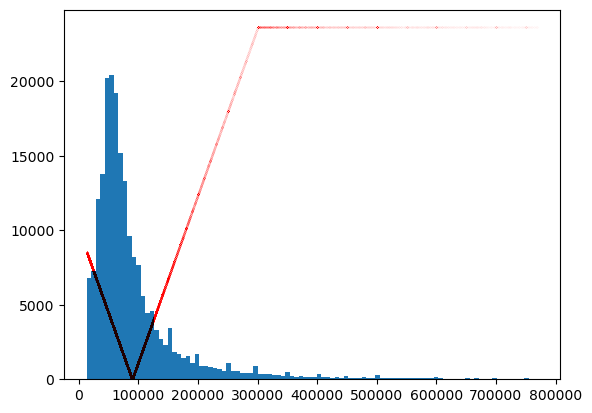

In [ ]:
# Загружаем лучшие предсказанные данные, которые набрали на кагле максимальный скор и делаем их калибровку
predict_df = pd.read_csv('/content/commit_v3.6__0.19_16000_s0.3_Перемешивание.csv', sep=",", decimal=".", encoding="windows-1251")
predict_df

,client_id,predict
0,208030,39940.870002
1,208031,77935.057273
2,208032,233891.216247
3,208033,51889.471698
4,208034,367413.951150
...,...,...
37178,245234,58921.472986
37179,245235,58921.472986
37180,245236,250892.635856
37181,245237,70150.960092


In [ ]:
# Выделение строк с диапазоном значений в колонке 'predict' от 85000 до 90000 и их замена на 85000
predict_df.loc[(predict_df['predict'] >= 85000) & (predict_df['predict'] <= 90000), 'predict'] = 85000
# Выделение строк с диапазоном значений в колонке 'predict' от 90000 до 95000 и их замена на 95000
predict_df.loc[(predict_df['predict'] > 90000) & (predict_df['predict'] <= 95000), 'predict'] = 95000

predict_df[['client_id','predict']].set_index('client_id').to_csv("commit.csv", sep=",", decimal=".")

# Куски кодов

In [ ]:
# Можем высчитать нужную нам метрику на заданном диапазоне итераций обученной модели
prediction_gen = model.staged_predict(
    X_test,
    ntree_start=3600,     # С какой начать
    ntree_end=5000,       # На какой закончить
    eval_period=100      # Шаг периодов между предсказаниями
)

try:
    for iteration, predict in enumerate(prediction_gen):
        WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)
        print(f"Итерация: {str(iteration)}, WMAE: {WMAE}")
except Exception:
    pass

In [ ]:
# Кросс валидация
from catboost import CatBoostRegressor
from catboost import Pool, cv

# Создание объекта Pool из обучающих данных
train_pool = Pool(X_train, y_train, cat_features=cat_feat_indices)

# Создание экземпляра CatBoostRegressor
model = CatBoostRegressor()

# Определение параметров кросс-валидации
params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'verbose': False
}

# Кросс-валидация
cv_data = cv(
    pool=train_pool,
    params=params,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    seed=0
)

# Вывод результатов кросс-валидации
print(cv_data)

В этом примере мы создаем объект train_pool из обучающих данных с указанием категориальных фичей в параметре cat_features. Затем мы создаем экземпляр CatBoostRegressor и определяем параметры модели.

Затем мы определяем параметры кросс-валидации в словаре params. В данном случае, мы указываем количество итераций, скорость обучения, функцию потерь и другие параметры модели.

Затем мы вызываем функцию cv() и передаем объект train_pool, параметры модели params, количество фолдов (fold_count), а также другие параметры кросс-валидации, такие как shuffle (перемешивание данных), partition_random_seed (случайное распределение фолдов) и stratified (стратифицированная кросс-валидация).

Результаты кросс-валидации сохраняются в объекте cv_data, который содержит информацию о значениях метрик для каждого фолда, а также средние значения метрик по всем фолдам.

# Блендинг предиктов

In [ ]:
# Блендим лучшие предикты
# Загружаем данные
df_pred1 = pd.read_csv('3.15_WMAE_27308.csv', sep=",", decimal=".", encoding="windows-1251")
df_pred2 = pd.read_csv('3.16_WMAE_27282.csv', sep=",", decimal=".", encoding="windows-1251")
df_pred3 = pd.read_csv('3.17_WMAE_27281.csv', sep=",", decimal=".", encoding="windows-1251")
df_pred4 = pd.read_csv('commit_combined_7.csv', sep=",", decimal=".", encoding="windows-1251")

pred1 = df_pred1['predict']
pred2 = df_pred2['predict']
pred3 = df_pred3['predict']
pred4 = df_pred4['predict']

# Веса для моделей
weights = [0.25, 0.27, 0.27, 0.21]  # Веса предиктов weights = [0.4, 0.3, 0.3]
# Блендинг прогнозов с использованием взвешенного среднего
blended_pred = np.average([pred1, pred2, pred3, pred4], axis=0, weights=weights)  # blended_pred содержит окончательные прогнозы, полученные путем блендинга моделей

test_df['predict'] = blended_pred
test_df[['client_id','predict']].set_index('client_id').to_csv("Blend13_0.25_0.27_0.27_0.21.csv", sep=",", decimal=".")

array([208269.13959479,  87426.5901391 , 247508.51515616, ...,
       263664.3910715 ,  62928.61180055, 506592.04483274])

In [ ]:
# Смотрим как отличаются веса у разных предиктов
df_pred1['3.17_WMAE_27281'] = df_pred1['predict']
df_pred1['3.16_WMAE_27282'] = df_pred2['predict']
df_pred1['3.15_WMAE_27308'] = df_pred3['predict']
df_pred1['commit_combined_3'] = df_pred4['predict']
aaa = df_pred1[['3.17_WMAE_27281','3.16_WMAE_27282','3.15_WMAE_27308','commit_combined_3']]
aaa

,3.17_WMAE_27281,3.16_WMAE_27282,3.15_WMAE_27308,commit_combined_4
0,189461.083119,222183.853721,231309.180099,154143.519733
1,94700.184536,83118.492075,90120.534741,81065.909215
2,245944.535110,242307.772731,251986.356500,255484.694498
3,51230.651225,48763.546860,51421.463602,65638.693762
4,448484.185827,452327.617822,392070.718463,416550.648510
...,...,...,...,...
37178,45409.809911,46267.276342,46492.931248,70136.556673
37179,45409.809911,46267.276342,46492.931248,70136.556673
37180,274423.211192,263607.129500,268977.374056,240125.327577
37181,60959.032592,57855.127289,61523.624208,78263.545848


# Логорифмирование

In [ ]:
# Лог-трансформация целевой переменной target
y_train_log = np.log1p(y_train)  # np.log1p() используется для избежания проблем с нулевыми значениями
# Для предсказания используем обратное преобразование predicta в вид изначального targeta
predictions = np.expm1(model.predict(X_test))  # np.expm1() - обратное преобразование логарифма

# Пробуем обрезать итерации у лучшей переобученной модели


In [ ]:
# Тренировочная дата
train_data = Pool(
    data = X_train,
    label = y_train,
    cat_features=cat_feat,
    weight = weight_train # Если хотим учиться с учётом веса
    )

# Валидационная дата
eval_data = Pool(
    data = X_test,
    label = y_test,
    cat_features=cat_feat,
    weight = weight_val # Если хотим учиться с учётом веса
    )

In [ ]:
# Загружаем обученную модель в model_5
# Сплит 0.33 w>0.03 версия блокнота v3.9
model_5 = CatBoostRegressor()
model_5.load_model('3.9_WMAE_28477')

# Получение количества деревьев
tree_count = model_5.tree_count_
print("Количество деревьев в модели CatBoost:", tree_count)

Количество деревьев в модели CatBoost: 498321


In [ ]:
model_5.shrink(91188)                                               # Обрезаем модель до итерации
predict = model_5.predict(X_test)                                   # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'depth=4 сплит {val_size} w>={w} (kaggle) (MAE: {int(WMAE)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что вес выше {w}')


depth=4 сплит 0.33 w>=0.03 (kaggle) (MAE: 28709) (WMAE: 28709) seed_split=666 валидация с полного набора. В трейн всё, что вес выше 0.03


In [ ]:
model_5.shrink(350085)                                              # Обрезаем модель до итерации
predict = model_5.predict(X_test)                                   # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'depth=4 сплит {val_size} w>={w} (kaggle) (MAE: {int(WMAE)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что вес выше {w}')

depth=4 сплит 0.33 w>=0.03 (kaggle) (MAE: 28506) (WMAE: 28506) seed_split=666 валидация с полного набора. В трейн всё, что вес выше 0.03


In [ ]:
model_5.shrink(200076)                                              # Обрезаем модель до итерации
predict = model_5.predict(X_test)                                   # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'depth=4 сплит {val_size} w>={w} (kaggle) (MAE: {int(WMAE)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что вес выше {w}')


depth=4 сплит 0.33 w>=0.03 (kaggle) (MAE: 28568) (WMAE: 28568) seed_split=666 валидация с полного набора. В трейн всё, что вес выше 0.03


In [ ]:
model_5.shrink(297778)                                              # Обрезаем модель до итерации
predict = model_5.predict(X_test)                                   # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'depth=4 сплит {val_size} w>={w} (kaggle) (MAE: {int(WMAE)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что вес выше {w}')

depth=4 сплит 0.33 w>=0.03 (kaggle) (MAE: 28523) (WMAE: 28523) seed_split=666 валидация с полного набора. В трейн всё, что вес выше 0.03


In [ ]:
model_5.shrink(350085)                                              # Обрезаем модель до итерации
predict = model_5.predict(X_test)                                   # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'depth=4 сплит {val_size} w>={w} (kaggle) (MAE: {int(WMAE)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что вес выше {w}')

depth=4 сплит 0.33 w>=0.03 (kaggle) (MAE: 28506) (WMAE: 28506) seed_split=666 валидация с полного набора. В трейн всё, что вес выше 0.03


In [ ]:
model_5.shrink(498320)                                              # Обрезаем модель до итерации
predict = model_5.predict(X_test)                                   # Предсказание на тренировочных
mae = mean_absolute_error(y_test, predict)                          # Вычисление метрики MAE       print("MAE:", mae)
WMAE = weighted_mean_absolute_error(y_test, predict, weight_val)    # Вычисление метрики WMAE      print(f"WMAE = {WMAE:.2f}")
print(f'depth=4 сплит {val_size} w>={w} (kaggle) (MAE: {int(WMAE)}) (WMAE: {int(WMAE)}) seed_split={seed_split} валидация с полного набора. В трейн всё, что вес выше {w}')

depth=4 сплит 0.33 w>=0.03 (kaggle) (MAE: 28477) (WMAE: 28477) seed_split=666 валидация с полного набора. В трейн всё, что вес выше 0.03


In [ ]:
test_df_pred = model_5.predict(test_df[feat_names])
test_df['predict'] = test_df_pred
test_df[['client_id','predict']].set_index('client_id').to_csv("3.9_91188_WMAE_28709.csv", sep=",", decimal=".")